In [1]:
# useful additional packages 
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import networkx as nx

from qiskit import Aer
from qiskit.aqua import QuantumInstance
from qiskit.circuit.library import TwoLocal, RealAmplitudes
from qiskit.tools.visualization import plot_histogram
from qiskit.optimization.applications.ising import tsp, max_cut
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit.aqua.algorithms import VQE, NumPyEigensolver
from qiskit.aqua.components.optimizers import SPSA, COBYLA

#from qiskit import IBMQ
#provider = IBMQ.load_account()

distance
 [[  0.  69.  56.  84.]
 [ 69.   0.  16. 100.]
 [ 56.  16.   0.  86.]
 [ 84. 100.  86.   0.]]


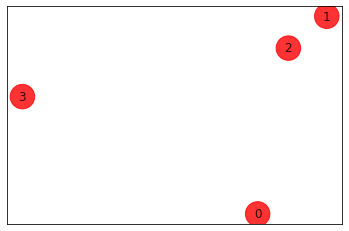

In [2]:
# Generating a graph of n nodes
n = 4

num_qubits = n ** 2
ins = tsp.random_tsp(n)
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))
colors = ['r' for node in G.nodes()]
pos = {k: v for k, v in enumerate(ins.coord)}
default_axes = plt.axes(frameon=True)
nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
print('distance\n', ins.w)

order = (0, 1, 2, 3) Distance = 255.0
Best order from brute force = (0, 1, 2, 3) with total distance = 255.0


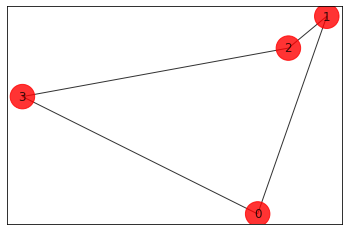

In [3]:
from itertools import permutations

def brute_force_tsp(w, N):
    a=list(permutations(range(1,N)))
    last_best_distance = 1e10
    for i in a:
        distance = 0
        pre_j = 0
        for j in i:
            distance = distance + w[j,pre_j]
            pre_j = j
        distance = distance + w[pre_j,0]
        order = (0,) + i
        if distance < last_best_distance:
            best_order = order
            last_best_distance = distance
            print('order = ' + str(order) + ' Distance = ' + str(distance))
    return last_best_distance, best_order
  
best_distance, best_order = brute_force_tsp(ins.w, ins.dim)
print('Best order from brute force = ' + str(best_order) + ' with total distance = ' + str(best_distance))

def draw_tsp_solution(G, order, colors, pos):
    G2 = G.copy()
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G2, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)

draw_tsp_solution(G, best_order, colors, pos)

In [4]:
qubitOp, offset = tsp.get_operator(ins)

energy: [-1600567.+0.j]
tsp objective: [255.+0.j]
feasible: True
solution: [2, 1, 0, 3]
solution objective: 255.0


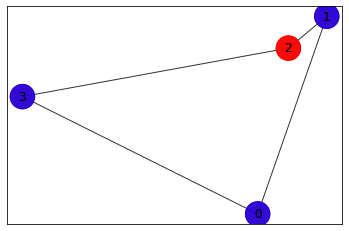

In [5]:
### Checking that the full Hamiltonian gives the right cost 
#Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector

from qiskit.aqua.algorithms import NumPyEigensolver
ee = NumPyEigensolver(qubitOp, k=1)
result = ee.run()

print('energy:', result['eigenvalues'])
print('tsp objective:', result['eigenvalues'] + offset)
x = sample_most_likely(result['eigenstates'][0])
print('feasible:', tsp.tsp_feasible(x))
z = tsp.get_tsp_solution(x)
print('solution:', z)
print('solution objective:', tsp.tsp_value(z, ins.w))
draw_tsp_solution(G, z, colors, pos)

colors = ['r' if tsp.get_tsp_solution(x)[i] == 0 else 'b' for i in range(n)]
nx.draw_networkx(G, node_color=colors, node_size=600, alpha = .8, pos=pos)

In [6]:
# Callback to print VQE iterations
def vqe_callback(count, params, mean, std):
    #print(count, params, mean, std)
    print(count, mean, std)

In [7]:
seed = 999

spsa = SPSA(max_trials=100)
#ry = TwoLocal(qubitOp.num_qubits, 'ry', 'cz', reps=5, entanglement='linear')
#ry = TwoLocal(qubitOp.num_qubits, 'ry', 'cz', reps=3, entanglement='full')
ry = RealAmplitudes(qubitOp.num_qubits, reps=3, entanglement='full')

vqe = VQE(qubitOp, ry, spsa, callback=vqe_callback)

backend = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)

result = vqe.run(quantum_instance)

print('energy:', result.eigenvalue.real)
print('time:', result.optimizer_time)
x = sample_most_likely(result.eigenstate)
print('feasible:', tsp.tsp_feasible(x))
z = tsp.get_tsp_solution(x)
print('solution:', z)
print('solution objective:', tsp.tsp_value(z, ins.w))
draw_tsp_solution(G, z, colors, pos)

/Users/sergiogago/opt/anaconda3/envs/qiskit24/lib/python3.8/site-packages/qiskit/aqua/components/optimizers/spsa.py:93: DeprecationWarning: The max_trials parameter is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use maxiter instead.
  warnings.warn('The max_trials parameter is deprecated as of '


1 18391.310546875 26201.41013668548
2 -45720.203125 25014.561813662203
3 -32787.662109374985 25373.58055697943
4 -50205.289062500015 24400.92896301408
5 -51377.50390625 25738.931957636087
6 115109.1298828125 25796.79857540128
7 40296.216796874985 26849.06730944388
8 -78371.4609375 23954.69416492204
9 -45698.951171875 25872.85659358979
10 -8586.814453125 24376.840521437654
11 1600.265625 24532.269054052787
12 -37125.3896484375 26449.76546911705
13 -15623.66015625 26287.943615213808
14 35586.4609375 26493.633714898897
15 -16014.3583984375 26869.58718180518
16 -21269.6181640625 24670.411944290037
17 32841.267578125 26381.143284737136
18 -57210.44238281249 23831.360049019702
19 32855.181640625 26250.421017555956
20 9022.9892578125 25045.919238690625
21 -73873.8662109375 26186.04413988445
22 76047.3662109375 25221.579492436995
23 27565.358398437515 26850.86900482551
24 -73256.76367187501 24606.188086152088
25 -100798.2421875 22691.167049555388
26 8407.984375 26415.059417208264
27 -44718.445

TypeError: unhashable type: 'list'

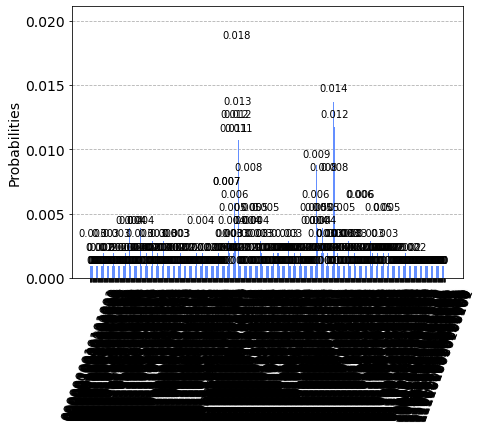

In [8]:
plot_histogram(result.eigenstate)